In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MLP network: 3.67M parameters, accuracy of 90%

CNN network: 3.58M parameters, accuracy of 98%

CNN network (kernel factorization): 3.38M parameters, accuracy of 97%

Block dropout delete an entire feature map and is more reasonable beacause all elements of a feature map learn the same feature 
but in different posistion.

In [3]:
#### Reading images 
import os
from torchvision.io import read_image
Path = "./Shoe vs Sandal vs Boot Dataset/"
tensor_size = (15000, 3, 102, 136)
class_path = ['Shoe', 'Sandal', 'Boot']  # label: [0, 1, 2] for softmax
Data_img = torch.zeros(tensor_size)
Data_label = torch.zeros(15000)
count = 0
for lab, c_path in enumerate(class_path):
    path = Path + c_path
    file_names = os.listdir(path)
    for name in file_names:
        img_path = os.path.join(path, name)
        img = read_image(img_path)
        if img.size() == Data_img[1, :, :, :].size():
            Data_img[count, :, :, :] = img/255
            Data_label[count] = lab
            count += 1
print(f'{count} images have been loaded')

14998 images have been loaded


(<matplotlib.image.AxesImage at 0x2a3399b3a90>, Text(0.5, 1.0, 'Label: Boot'))

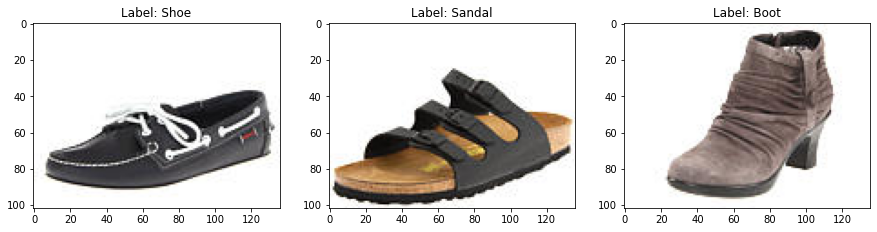

In [4]:
image1 = Data_img[1, :, :, :]; label1 = Data_label[1]; label1 = label1.to(torch.long)
image2 = Data_img[5001, :, :, :]; label2 = Data_label[5001]; label2 = label2.to(torch.long)
image3 = Data_img[10001, :, :, :]; label3 = Data_label[10001]; label3 = label3.to(torch.long)
image1 = image1.permute(1, 2, 0); 
image2 = image2.permute(1, 2, 0); 
image3 = image3.permute(1, 2, 0); 

plt.figure(1, figsize=(15, 17))
plt.subplot(1, 3, 1)
plt.imshow(image1), plt.title(f'Label: {class_path[label1]}')
plt.subplot(1, 3, 2)
plt.imshow(image2), plt.title(f'Label: {class_path[label2]}')
plt.subplot(1, 3, 3)
plt.imshow(image3), plt.title(f'Label: {class_path[label3]}')

In [5]:
from torchvision import transforms
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, Images, Labels, transform = None, target_transform = None):
        self.Images = Images
        self.Labels = Labels
        self.transform = transform 
        self.target_transform = target_transform
    def __len__(self):
        return len(self.Images)
    def __getitem__(self, idx):
        Img = self.Images[idx, :, :, :]
        lable = self.Labels[idx]
        if self.transform:
            Img = self.transform(Img)
            lable = self.target_transform(lable, dtype = torch.long)
        return Img, lable

In [6]:
#### Create a Dataset Object and (0.7, 0.3) splitting
from torch.utils.data import random_split
All_Data = MyDataset(Data_img, Data_label);
SplitData = random_split(All_Data, [0.70, 0.30])
Train = SplitData[0]
Test = SplitData[1]
print(len(All_Data), len(Train), len(Test))

15000 10500 4500


In [8]:
from torch.utils.data import DataLoader
batch_size = 64
train_dataloader = DataLoader(Train, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(Test, batch_size = batch_size, shuffle = True)

In [15]:
import torch.nn as nn
class NeNet_MLP(nn.Module):
    def __init__(self):
        super(NeNet_MLP, self).__init__()
        self.avgpool = nn.AvgPool3d((3, 2, 2), 2)
        self.flatten = nn.Flatten()
        self.Linear_Relu = nn.Sequential(
        #nn.Dropout(p = 0.2),
        nn.Linear(in_features=3468, out_features=900), 
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features=900, out_features=500),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features=500, out_features=200),
        nn.ReLU(), 
        nn.Linear(in_features=200, out_features=3),
        nn.ReLU())
    def forward(self, X):
        X = self.avgpool(X)
        X = self.flatten(X)
        logits = self.Linear_Relu(X)
        return logits

class NeNet_CNN(nn.Module):
    def __init__(self):
        super(NeNet_CNN, self).__init__()
        self.Conv_Layers = nn.Sequential(
        nn.Conv2d(in_channels= 3, out_channels= 100, kernel_size= (3, 3), stride= 2),
        nn.BatchNorm2d(num_features= 100),
        nn.ReLU(),
        nn.Conv2d(in_channels= 100, out_channels= 100, padding= 'same', kernel_size= (3, 3), stride= 1),
        nn.BatchNorm2d(num_features= 100),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 100, out_channels= 150, kernel_size= (3, 3), stride= 2),
        nn.BatchNorm2d(num_features= 150),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 150, out_channels= 200, padding = 'same', kernel_size= (3, 3), stride= 1),
        nn.BatchNorm2d(num_features= 200),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 200, out_channels= 200, kernel_size= (3, 3), stride= 2),
        nn.BatchNorm2d(num_features= 200),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 200, out_channels= 400, padding = 'same', kernel_size= (3, 3), stride= 1),
        nn.BatchNorm2d(num_features= 400),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 400, out_channels= 500, kernel_size= (3, 3), stride= 2),
        nn.BatchNorm2d(num_features= 500),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size= (5, 7)),
        nn.Flatten(),
        nn.Linear(in_features=500, out_features=400),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features=400, out_features=3),
        nn.ReLU()
        )
    def forward(self, X):
        logits = self.Conv_Layers(X)
        return logits

class NeNet_CompCNN(nn.Module):
    def __init__(self):
        super(NeNet_CompCNN, self).__init__()
        self.Conv_Layers = nn.Sequential(
        nn.Conv2d(in_channels= 3, out_channels= 100, kernel_size= (3, 3), stride= 2),
        nn.BatchNorm2d(num_features= 100),
        nn.ReLU(),
        nn.Conv2d(in_channels= 100, out_channels= 100, padding= 'same', kernel_size= (3, 3), stride= 1),
        nn.BatchNorm2d(num_features= 100),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 100, out_channels= 150, kernel_size= (3, 1), stride= (2, 1)),
        nn.BatchNorm2d(num_features= 150),
        nn.ReLU(),
        nn.Conv2d(in_channels= 150, out_channels= 150, kernel_size= (1, 3), stride= (1, 2)),
        nn.BatchNorm2d(num_features= 150),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 150, out_channels= 200, padding = 'same', kernel_size= (3, 1), stride= 1),
        nn.BatchNorm2d(num_features= 200),
        nn.ReLU(),
        nn.Conv2d(in_channels= 200, out_channels= 200, padding = 'same', kernel_size= (1, 3), stride= 1),
        nn.BatchNorm2d(num_features= 200),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 200, out_channels= 200, kernel_size= (3, 1), stride= (2, 1)),
        nn.BatchNorm2d(num_features= 200),
        nn.ReLU(),
        nn.Conv2d(in_channels= 200, out_channels= 200, kernel_size= (1, 3), stride= (1, 2)),
        nn.BatchNorm2d(num_features= 200),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 200, out_channels= 400, padding = 'same', kernel_size= (1, 3), stride= 1),
        nn.BatchNorm2d(num_features= 400),
        nn.ReLU(),
        nn.Conv2d(in_channels= 400, out_channels= 400, padding = 'same', kernel_size= (3, 1), stride= 1),
        nn.BatchNorm2d(num_features= 400),
        nn.ReLU(),
        nn.Dropout2d(p = 0.15),
        nn.Conv2d(in_channels= 400, out_channels= 500, kernel_size= (3, 3), stride= 2),
        nn.BatchNorm2d(num_features= 500),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size= (5, 7)),
        nn.Flatten(),
        nn.Linear(in_features=500, out_features=400),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features=400, out_features=3),
        nn.ReLU()
        )
    def forward(self, X):
        logits = self.Conv_Layers(X)
        return logits

In [10]:
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
Lr = 1e-4
epoch_mlp = 20
device = 'cuda' if torch.cuda.is_available else 'cpu'
model_MLP = NeNet_MLP()
model_MLP = model_MLP.to(device)
optimizer_MLP = torch.optim.Adam(params= model_MLP.parameters(), lr=Lr, weight_decay=0.0)
#optimizer = torch.optim.SGD(params= model.parameters(), lr=Lr)
loss_func_mlp = nn.CrossEntropyLoss()
summary(model_MLP, (3, 102, 136))
writer_mlp = SummaryWriter()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AvgPool3d-1            [-1, 1, 51, 68]               0
           Flatten-2                 [-1, 3468]               0
            Linear-3                  [-1, 900]       3,122,100
              ReLU-4                  [-1, 900]               0
           Dropout-5                  [-1, 900]               0
            Linear-6                  [-1, 500]         450,500
              ReLU-7                  [-1, 500]               0
           Dropout-8                  [-1, 500]               0
            Linear-9                  [-1, 200]         100,200
             ReLU-10                  [-1, 200]               0
           Linear-11                    [-1, 3]             603
             ReLU-12                    [-1, 3]               0
Total params: 3,673,403
Trainable params: 3,673,403
Non-trainable params: 0
---------------------------

In [11]:
Lr = 2e-4
epoch_cnn = 15
model_CNN = NeNet_CNN()
model_CNN = model_CNN.to(device)
optimizer_CNN = torch.optim.Adam(params= model_CNN.parameters(), lr=Lr, weight_decay=0.0)
#optimizer = torch.optim.SGD(params= model.parameters(), lr=Lr)
loss_func_cnn = nn.CrossEntropyLoss()
summary(model_CNN, (3, 102, 136))
writer_cnn = SummaryWriter()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 50, 67]           2,800
       BatchNorm2d-2          [-1, 100, 50, 67]             200
              ReLU-3          [-1, 100, 50, 67]               0
            Conv2d-4          [-1, 100, 50, 67]          90,100
       BatchNorm2d-5          [-1, 100, 50, 67]             200
              ReLU-6          [-1, 100, 50, 67]               0
         Dropout2d-7          [-1, 100, 50, 67]               0
            Conv2d-8          [-1, 150, 24, 33]         135,150
       BatchNorm2d-9          [-1, 150, 24, 33]             300
             ReLU-10          [-1, 150, 24, 33]               0
        Dropout2d-11          [-1, 150, 24, 33]               0
           Conv2d-12          [-1, 200, 24, 33]         270,200
      BatchNorm2d-13          [-1, 200, 24, 33]             400
             ReLU-14          [-1, 200,

In [16]:
Lr = 2e-4
epoch_ccnn = 15
model_CCNN = NeNet_CompCNN()
model_CCNN = model_CCNN.to(device)
optimizer_CCNN = torch.optim.Adam(params= model_CCNN.parameters(), lr=Lr, weight_decay=0.0)
#optimizer = torch.optim.SGD(params= model.parameters(), lr=Lr)
loss_func_ccnn = nn.CrossEntropyLoss()
summary(model_CCNN, (3, 102, 136))
writer_ccnn = SummaryWriter()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 50, 67]           2,800
       BatchNorm2d-2          [-1, 100, 50, 67]             200
              ReLU-3          [-1, 100, 50, 67]               0
            Conv2d-4          [-1, 100, 50, 67]          90,100
       BatchNorm2d-5          [-1, 100, 50, 67]             200
              ReLU-6          [-1, 100, 50, 67]               0
         Dropout2d-7          [-1, 100, 50, 67]               0
            Conv2d-8          [-1, 150, 24, 67]          45,150
       BatchNorm2d-9          [-1, 150, 24, 67]             300
             ReLU-10          [-1, 150, 24, 67]               0
           Conv2d-11          [-1, 150, 24, 33]          67,650
      BatchNorm2d-12          [-1, 150, 24, 33]             300
             ReLU-13          [-1, 150, 24, 33]               0
        Dropout2d-14          [-1, 150,

In [17]:
def train_loop(Model, Optimizer, Loss_Func, dataloader, kep, writer):
    LD = len(dataloader.dataset)
    for i, (X, y) in enumerate(dataloader):
        y.squeeze_()
        y = y.to(torch.long)
        X, y = X.to(device), y.to(device)
        ypred = Model(X)
        loss = Loss_Func(ypred, y)
        Optimizer.zero_grad()
        loss.backward()
        Optimizer.step()
        if i % 50 == 0:
            
            print(f'loss = {loss.item():5f}     [{i*batch_size:5}\{LD:5}]')
            writer.add_scalar('Loss/train', loss, i + kep*len(dataloader))
def test_loop(Model, loss_func, dataloader, kep, writer):
    LD = len(dataloader.dataset)
    LB = len(dataloader)
    loss = 0
    Accu = 0
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y.squeeze_()
        y = y.to(torch.long)
        with torch.no_grad():
            ypred = Model(X)
            loss += loss_func(ypred, y)
            Accu += (torch.argmax(ypred, dim = 1)==y).type(torch.float).sum().item()
    print(f'Test/Val Loss = {loss.item()/LB:5f}  ,  Accuracy = {100*Accu/LD:2f}%')
    writer.add_scalar('Loss/test', loss/LB, i + kep*len(dataloader))

def final_test(Model, dataloader):
    LD = len(dataloader.dataset)
    LB = len(dataloader)
    y_true = []; y_pred = [];
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y.squeeze_()
        y = y.to(torch.long)
        with torch.no_grad():
            ypred = Model(X)
            ypred = torch.argmax(ypred, dim = 1)
        y_pred.extend(ypred.tolist())
        y_true.extend(y.tolist())
    return y_true, y_pred

In [82]:
for k in range(epoch_mlp):
    print(f'\nEpoch: {k}-----------------------------------------')
    model_MLP.train()
    train_loop(model_MLP, optimizer_MLP, loss_func_mlp, train_dataloader, k, writer_mlp)
    model_MLP.eval()
    test_loop(model_MLP, loss_func_mlp, test_dataloader, k, writer_mlp)
print('Done!')


Epoch: 0-----------------------------------------
loss = 1.098311     [    0\10500]
loss = 0.804051     [ 3200\10500]
loss = 0.620910     [ 6400\10500]
loss = 0.547153     [ 9600\10500]
Test/Val Loss = 0.492361  ,  Accuracy = 78.800000%

Epoch: 1-----------------------------------------
loss = 0.677047     [    0\10500]
loss = 0.369388     [ 3200\10500]
loss = 0.621084     [ 6400\10500]
loss = 0.460544     [ 9600\10500]
Test/Val Loss = 0.409842  ,  Accuracy = 83.311111%

Epoch: 2-----------------------------------------
loss = 0.429553     [    0\10500]
loss = 0.483291     [ 3200\10500]
loss = 0.310465     [ 6400\10500]
loss = 0.398781     [ 9600\10500]
Test/Val Loss = 0.365424  ,  Accuracy = 86.377778%

Epoch: 3-----------------------------------------
loss = 0.514926     [    0\10500]
loss = 0.345500     [ 3200\10500]
loss = 0.310770     [ 6400\10500]
loss = 0.256407     [ 9600\10500]
Test/Val Loss = 0.331362  ,  Accuracy = 87.844444%

Epoch: 4---------------------------------------

Precision for classes 'Shoe', 'Sandal', 'Boot': [0.9428778  0.8458231  0.94895903] 

Recall for classes 'Shoe', 'Sandal', 'Boot': [0.85564304 0.94057377 0.93452381]


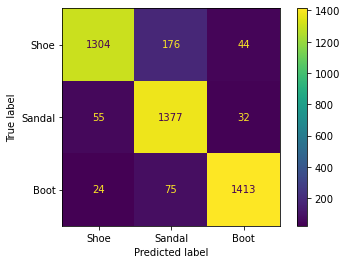

In [106]:
from sklearn import metrics
y_true, y_pred = final_test(model_MLP, test_dataloader)
confmat = metrics.confusion_matrix(np.array(y_true), np.array(y_pred))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confmat, display_labels = class_path)

Precision = confmat[[0, 1, 2], [0, 1, 2]]/confmat.sum(axis = 0)
Recall = confmat[[0, 1, 2], [0, 1, 2]]/confmat.sum(axis = 1)
print(f'Precision for classes \'Shoe\', \'Sandal\', \'Boot\': {Precision} \n')
print(f'Recall for classes \'Shoe\', \'Sandal\', \'Boot\': {Recall}')
cm_display.plot()
plt.show()

In [83]:
writer_mlp.flush()
writer_mlp.close() 
%load_ext tensorboard
%tensorboard --logdir='runs' --port=8892 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8892 (pid 15164), started 7:02:03 ago. (Use '!kill 15164' to kill it.)

In [87]:
for k in range(epoch_cnn):
    print(f'\nEpoch: {k}-----------------------------------------')
    model_CNN.train()
    train_loop(model_CNN, optimizer_CNN, loss_func_cnn, train_dataloader, k, writer_cnn)
    model_CNN.eval()
    test_loop(model_CNN, loss_func_cnn, test_dataloader, k, writer_cnn)
print('Done!')


Epoch: 0-----------------------------------------
loss = 1.100708     [    0\10500]
loss = 0.710753     [ 3200\10500]
loss = 0.566957     [ 6400\10500]
loss = 0.445272     [ 9600\10500]
Test/Val Loss = 0.341230  ,  Accuracy = 87.133333%

Epoch: 1-----------------------------------------
loss = 0.391627     [    0\10500]
loss = 0.308786     [ 3200\10500]
loss = 0.403929     [ 6400\10500]
loss = 0.178486     [ 9600\10500]
Test/Val Loss = 0.220056  ,  Accuracy = 92.155556%

Epoch: 2-----------------------------------------
loss = 0.164978     [    0\10500]
loss = 0.138267     [ 3200\10500]
loss = 0.323922     [ 6400\10500]
loss = 0.237702     [ 9600\10500]
Test/Val Loss = 0.170969  ,  Accuracy = 94.955556%

Epoch: 3-----------------------------------------
loss = 0.202360     [    0\10500]
loss = 0.113294     [ 3200\10500]
loss = 0.166423     [ 6400\10500]
loss = 0.141085     [ 9600\10500]
Test/Val Loss = 0.133061  ,  Accuracy = 95.133333%

Epoch: 4---------------------------------------

Precision for classes 'Shoe', 'Sandal', 'Boot': [0.97383911 0.97756628 0.988     ] 

Recall for classes 'Shoe', 'Sandal', 'Boot': [0.97703412 0.98224044 0.98015873]


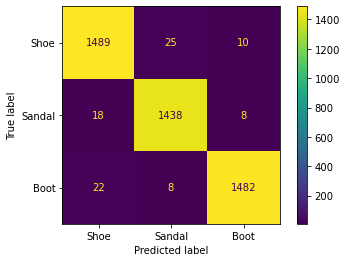

In [107]:
# Confusion Matrix for CNN model
y_true, y_pred = final_test(model_CNN, test_dataloader)
confmat = metrics.confusion_matrix(np.array(y_true), np.array(y_pred))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confmat, display_labels = class_path)

Precision = confmat[[0, 1, 2], [0, 1, 2]]/confmat.sum(axis = 0)
Recall = confmat[[0, 1, 2], [0, 1, 2]]/confmat.sum(axis = 1)
print(f'Precision for classes \'Shoe\', \'Sandal\', \'Boot\': {Precision} \n')
print(f'Recall for classes \'Shoe\', \'Sandal\', \'Boot\': {Recall}')
cm_display.plot()
plt.show()

In [5]:
writer_cnn.flush()
writer_cnn.close() 
%load_ext tensorboard
%tensorboard --logdir='runs' --port=8893 

In [18]:
for k in range(epoch_ccnn):
    print(f'\nEpoch: {k}-----------------------------------------')
    model_CCNN.train()
    train_loop(model_CCNN, optimizer_CCNN, loss_func_ccnn, train_dataloader, k, writer_ccnn)
    model_CCNN.eval()
    test_loop(model_CCNN, loss_func_ccnn, test_dataloader, k, writer_ccnn)
print('Done!')


Epoch: 0-----------------------------------------
loss = 1.094280     [    0\10500]
loss = 0.682080     [ 3200\10500]
loss = 0.593112     [ 6400\10500]
loss = 0.366031     [ 9600\10500]
Test/Val Loss = 0.368793  ,  Accuracy = 86.044444%

Epoch: 1-----------------------------------------
loss = 0.295059     [    0\10500]
loss = 0.281834     [ 3200\10500]
loss = 0.202739     [ 6400\10500]
loss = 0.312726     [ 9600\10500]
Test/Val Loss = 0.426132  ,  Accuracy = 83.333333%

Epoch: 2-----------------------------------------
loss = 0.273516     [    0\10500]
loss = 0.188246     [ 3200\10500]
loss = 0.097861     [ 6400\10500]
loss = 0.102337     [ 9600\10500]
Test/Val Loss = 0.247709  ,  Accuracy = 91.022222%

Epoch: 3-----------------------------------------
loss = 0.085080     [    0\10500]
loss = 0.131443     [ 3200\10500]
loss = 0.152716     [ 6400\10500]
loss = 0.073514     [ 9600\10500]
Test/Val Loss = 0.178180  ,  Accuracy = 94.000000%

Epoch: 4---------------------------------------

Precision for classes 'Shoe', 'Sandal', 'Boot': [0.94448031 0.98735067 0.98232984] 

Recall for classes 'Shoe', 'Sandal', 'Boot': [0.98319892 0.95254237 0.97657775]


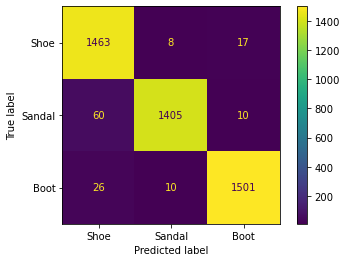

In [20]:
# Confusion Matrix for CompCNN model (Kernel factorization)
from sklearn import metrics
#y_true, y_pred = final_test(model_CCNN, test_dataloader)
confmat = metrics.confusion_matrix(np.array(y_true), np.array(y_pred))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confmat, display_labels = class_path)

Precision = confmat[[0, 1, 2], [0, 1, 2]]/confmat.sum(axis = 0)
Recall = confmat[[0, 1, 2], [0, 1, 2]]/confmat.sum(axis = 1)
print(f'Precision for classes \'Shoe\', \'Sandal\', \'Boot\': {Precision} \n')
print(f'Recall for classes \'Shoe\', \'Sandal\', \'Boot\': {Recall}')
cm_display.plot()
plt.show()

In [4]:
writer_ccnn.flush()
writer_ccnn.close() 
%load_ext tensorboard
%tensorboard --logdir='runs' --port=8893